# Causal Forest - Double Machine Learning Model (DML)

This file is part of the reproduction package provided with the paper Understanding Dark Personality Traits and Strategic Choices in an Inspection Game.

This notebook contains the causal forest model, including the first-stage models selection procedure, causal forest. tuning, deployment and analysis

Questions and correspondence should be addressed to Vinícius Ferraz (visferraz@gmail.com).

In [2]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Scikit-learn: Base and Metrics
from sklearn.base import clone
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    make_scorer, f1_score, 
    balanced_accuracy_score,
    matthews_corrcoef,
    accuracy_score, 
    r2_score
)

# Scikit-learn: Model Selection and Cross Validation
from sklearn.model_selection import train_test_split, GroupKFold, KFold, StratifiedKFold, ParameterGrid

# Scikit-learn: Models
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    GradientBoostingRegressor, RandomForestRegressor
    )
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import Lasso

# Imbalanced Learn
from imblearn.pipeline import Pipeline

# EconML
from econml.dml import CausalForestDML
from econml.sklearn_extensions.model_selection import GridSearchCVList, GridSearchCV

# Joblib for Model Persistence
from joblib import dump, load

# SHAP for model explanations
import shap

# Jupyter Notebook Settings
%matplotlib inline

## Data Definitions

In [3]:
df_full = pd.read_csv('data/df_rep_p.csv')
df_os = pd.read_csv('data/df_os_p.csv')

In [4]:
df_full_p1 = df_full.loc[df_full['player_id']==1]
df_full_p2 = df_full.loc[df_full['player_id']==2]
df_os_p1 = df_os.loc[df_os['player_type']==1]
df_os_p2 = df_os.loc[df_os['player_type']==2]

In [5]:
# model variables

# covariates - repeated game (X)
covs =  ['D-factor','Age', 'Female', 'STEM']
# confounding variables - repeated game (W)
confs = [ 'Own S1 Freq. (t-1)', 'Opponent S1 (t-1)']

# covariates - one-shot game (X)
covs_os = ['D-factor', 'Age', 'Female', 'STEM', 'Dishonesty Score']

In [6]:
train, test = train_test_split(df_full, test_size=0.2, random_state = 42)
# Define model variables
y = train['s1'] 
T = train['Framing']
X = train[covs]
W = train[confs]
X_test = test[covs]
y_test = test['s1'] 

train_p1, test_p1 = train_test_split(df_full_p1, test_size=0.2, random_state = 42)
y_1 = train_p1['s1'] 
T_1 = train_p1['Framing']
X_1 = train_p1[covs]
W_1 = train_p1[confs]
X_test_1 = test_p1[covs]
y_test_1 = test_p1['s1'] 

train_p2, test_p2 = train_test_split(df_full_p2, test_size=0.2, random_state = 42)
y_2 = train_p2['s1'] 
T_2 = train_p2['Framing']
X_2 = train_p2[covs]
W_2 = train_p2[confs]
X_test_2 = test_p2[covs]
y_test_2 = test_p2['s1'] 

In [7]:
train_os, test_os = train_test_split(df_os, test_size=0.2, random_state = 43)

# Define model variables
y_os = train_os['s1'] 
T_os = train_os['Framing']
X_os = train_os[covs_os]
X_test_os = test_os[covs_os]
y_test_os = test_os['s1'] 

train_p1_os, test_p1_os = train_test_split(df_os_p1, test_size=0.2, random_state = 43)
y_1_os = train_p1_os['s1'] 
T_1_os = train_p1_os['Framing']
X_1_os = train_p1_os[covs_os]
X_test_1_os = test_p1_os[covs_os]
y_test_1_os = test_p1_os['s1'] 

train_p2_os, test_p2_os = train_test_split(df_os_p2, test_size=0.2, random_state = 43)
y_2_os = train_p2_os['s1'] 
T_2_os = train_p2_os['Framing']
X_2_os = train_p2_os[covs_os]
X_test_2_os = test_p2_os[covs_os]
y_test_2_os = test_p2_os['s1'] 

## Main Code

**First-Stage Model Selection Procedure:** <br><br>
The model_selection function employs a grid search algorithm to systematically identify the best-performing model from a predefined set of machine learning classifiers, including Multilayer Perceptron, Random Forest, and Gradient Boosting Machines. Utilizing metrics such as AUC, F1 score, Balanced Accuracy, and MCC for evaluation, the function selects the best model based on the highest AUC value. The function also incorporates cross-validation, allowing for either Group K-Fold or Stratified K-Fold, to ensure robust and generalizable performance.

In [8]:
def model_selection(X, y, model_type='classifier', groups=None, use_groups=True, cv_folds=3, dataset='rg'):

    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=UserWarning)

    print('Models Evaluation Started...')
    print('')
    
    if dataset == 'os': # reduced NN complexity for the smaller datesets, to avoid overfitting
        mlp_param_grid = {
            'model__hidden_layer_sizes': [(50,), (50, 50), (100,)],
            'model__activation': ['relu', 'tanh', 'logistic'],
            'model__solver': ['adam', 'sgd'],
            'model__alpha': [0.01,0.1, 0.25, 0.5],
            'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
            'model__learning_rate_init': [0.001, 0.01, 0.1, 0.2],
            'model__warm_start': [False]
        }
        
        max_depth_limit = [1, 5, 10, 15] # deep trees are not good in this small datasets either
        
    else:
        mlp_param_grid = {
            'model__hidden_layer_sizes': [(50,), (100,), (150,), (50, 50), (100, 100), 
                                               (100, 50, 25), (100, 100, 100), (150,150,150)],
            'model__activation': ['relu', 'tanh', 'logistic'],
            'model__solver': ['adam', 'sgd'],
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 0.25],
            'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
            'model__learning_rate_init': [0.001, 0.01, 0.1, 0.2],
            'model__warm_start': [True, False]
        }
        
        max_depth_limit = [1, 5, 10, 20, 40] # trees can go deeper on the bigger dataset
    
    # Shared models for classifiers and regressors
    param_grid_list = [
            mlp_param_grid,
        
            {   # Random Forest 
                'model__n_estimators': [400, 800, 1000],
                'model__max_depth': max_depth_limit,
                'model__min_samples_leaf': [1, 5, 10, 20, 30],
                'model__max_features': ['sqrt', 'log2'],
                'model__criterion': ['gini', 'entropy'],
                'model__bootstrap': [True, False]
            },
            {   # Gradient Boosting Machines
                'model__n_estimators': [400, 800, 1000],
                'model__learning_rate': [0.01, 0.05, 0.1],
                'model__max_depth':  max_depth_limit,
                'model__min_samples_leaf': [1, 5, 10, 20, 30],
                'model__max_features': ['sqrt', 'log2'],
                'model__criterion': ['friedman_mse', 'squared_error']
            }
    ]
    
    if model_type == 'classifier':
        
        # Evaluated classifier models 
        models = [
            MLPClassifier(random_state = 42, max_iter = 10000, early_stopping=True,),
            RandomForestClassifier(random_state = 42),
            GradientBoostingClassifier(random_state = 42),
            GaussianNB(),
        ]

        # Define fit and scoring metrics
        scoring_metrics = {
        'AUC': 'roc_auc', 
        'F1': make_scorer(f1_score), 
        'MCC': make_scorer(matthews_corrcoef), 
        'Balanced_Accuracy': make_scorer(balanced_accuracy_score),
        'MSE': make_scorer(mean_squared_error, greater_is_better = False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better = False), 
        }
        # Refit metric
        refit_metric = 'AUC'

        # Parameter search grids 
        NB_p = {}
        param_grid_list.append(NB_p)
        
    elif model_type == 'regressor':

        # Evaluated regressor models 
        models = [
            MLPRegressor(random_state = 42, max_iter = 10000, early_stopping=True),
            RandomForestRegressor(random_state = 42),
            GradientBoostingRegressor(random_state = 42),
            Lasso(random_state = 42),
        ]
        
        # Define fit and scoring metrics
        scoring_metrics = {
        'MSE': make_scorer(mean_squared_error, greater_is_better = False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better = False), 
        'R2': make_scorer(r2_score),
        }
        # Refit metric
        refit_metric = 'MSE'
        
        lasso_p = {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                   'model__max_iter': [1000, 5000, 10000],
                   'model__tol': [1e-4, 1e-3, 1e-2],
                   'model__fit_intercept': [True, False],
                   'model__selection': ['cyclic', 'random']}

        param_grid_list.append(lasso_p)
        # replacing classifier criteria (for random forest)
        param_grid_list[1]['model__criterion'] = ['absolute_error', 'poisson', 'friedman_mse', 'squared_error']
        param_grid_list[1]['model__class_weight'] = ['balanced', 'balanced_subsample']
        
    else:
        raise ValueError("Invalid model_type. Choose either 'classifier' or 'regressor'.")
        
    pipeline_name = 'model'
    
    model_scores = {}
    
    #cv_folds = 3 # Define of how many cross-validation folds should be employed
    
    # Define CV strategy based on the 'use_groups' flag
    if use_groups:
        cv = GroupKFold(n_splits=cv_folds)
    else:
        if model_type == 'classifier':
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        else:  # for regression
            cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Grid Search
    best_score = -float('inf')
    best_model = None
    best_params = None
    
    # Building and testing the models
    for model, params in zip(models, param_grid_list):  
        model_name = type(model).__name__
        print(f"{model_name} started") 
        
        try:
            pipeline = Pipeline([(pipeline_name, model)])

            grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, 
                                       scoring=scoring_metrics, refit=refit_metric,
                                       verbose=1, n_jobs=-1) # n_jobs = -1 uses all available cores

            if use_groups:
                grid_search.fit(X, y, groups=groups)
            else:
                grid_search.fit(X, y)

            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_
                best_model = grid_search.best_estimator_
                best_params = grid_search.best_params_

            model_scores[model_name] = grid_search.best_score_

            print(f"{model_name} finished")
            print('')

        except Exception as e: 
            print(f"An error occurred with {type(model).__name__}: {e}")   

    print("Scores of all models: ", model_scores)
    
    if best_model is not None:  # Added this line
        print(f"Best score: {best_score}") 
        print(f"Selected Model: {type(best_model.named_steps[pipeline_name]).__name__}") 
        print(f"Model Architecture: {best_params}") 
    else:  
        print("No model could be fitted.")  
        
    print('')
    return clone(best_model)

**DML Model Tuning and Fitting:** <br><br>
The functions tune_CausalForestDML and fit_CausalForestDML are designed for tuning and fitting a CausalForestDML model, respectively. The tuning function takes as input pre-trained machine learning models for both the treatment (model_t) and outcome (model_y), and utilizes the native tuning function of the econml library to optimize the hyperparameters. It employs 5-fold cross-validation for robust performance and saves the tuned model for future use. The fitting function then loads this tuned model to fit the data and predict the Conditional Average Treatment Effects (CATE). It calculates and returns key performance metrics such as Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) on the training set.

In [9]:
def tune_CausalForestDML(model_y_name, model_t_name, y, T, X, W, dml_name):
    
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    
    model_y = load_model(model_y_name)
    model_t = load_model(model_t_name)
    
    # Basic model instance
    dml_model = CausalForestDML(model_t=model_t,
                                model_y=model_y,
                                n_estimators=1000,
                                inference=True,
                                random_state=43,
                                discrete_treatment=True,
                                cv=10,
                                n_jobs=-1,
                                drate=True)
    
    # Model tuning (econml native tuning function)
    dml_model.tune(y, T, X=X, W=W)
    # Saving the tuned model for future use
    save_model(dml_model, dml_name) 
    print(str(dml_name) + ' model saved')

def fit_tuned_CausalForestDML(y, T, X, W, dml_name):
    
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    
    # Load the saved tuned model
    dml_model = load_model(dml_name)
    dml_model.min_var_leaf_on_val = True # ensuring variance criterion
    dml_model.min_var_fraction_leaf = 0.05 # estabilthing a minimum variance value (for SHAP computation)
    # Model fit 
    dml_model.fit(y, T, X=X, W=W)
    # CATE on training set
    te_X = dml_model.effect(X)
    # Root mean squared error on training set
    rmse_train = mean_squared_error(y, te_X, squared=False)
    # Mean average error on training set
    mae_train = mean_absolute_error(y, te_X)
    
    print('Finished')
    return dml_model, te_X, rmse_train, mae_train

**Models Management**

The save_model function serializes and saves the given machine learning model to disk, storing it in a specified file. This allows for the persistence of trained models, facilitating their reuse in future runs or deployments. The load_model function does the opposite; it deserializes and loads a previously saved model from disk into memory. This ensures that optimized or trained models can be quickly reutilized without the need for retraining.

In [10]:
def save_model(model, filename):
    dump(model, filename) 

def load_model(filename):
    return load(filename)

**CATE Prediction**

predict_Cate evaluates the Causal Average Treatment Effect (CATE) on a test set for multiple models. It calculates the mean treatment effect, root mean squared error (RMSE) and mean absolute error (MAE) for the average treatment effect (ATE) for each model. The results are returned as a DataFrame for easy comparison and analysis. 

In [11]:
def predict_CATE(model_data_dict):
    results = []
    
    for model_name, data in model_data_dict.items():
        model = data['model']
        X_test = data['X_test']
        y_test = data['y_test']
        
        # Predict CATE on test set
        te_X_test = model.effect(X_test)
        
        # Root mean squared error on test set
        rmse_test = mean_squared_error(y_test, te_X_test, squared=False)
        
        # Mean average error on test set
        mae_test = mean_absolute_error(y_test, te_X_test)
        
        # Get p-value for ATE
        ate_inf = model.ate(X_test)
        
        results.append({
            'Model': model_name,
            'ATE': np.mean(te_X_test),
            'RMSE': rmse_test,
            'MAE': mae_test,
        })
    
    return pd.DataFrame(results)

**CATE Visualization**

The plot_treatment_effects function is designed to plot the ordered treatment effects on the observation level, including their confidence intervals. 

In [12]:
 def plot_treatment_effects(model_X_pairs):
    fig, axes = plt.subplots(2, len(model_X_pairs), figsize=(3 * len(model_X_pairs), 5), sharey='row')
    
    # Find global min and max for treatment effects to set xlim for histograms
    global_min = np.inf
    global_max = -np.inf
    
    for model_name, (model, X) in model_X_pairs.items():
        treatment_effects = model.effect(X)
        global_min = min(global_min, np.min(treatment_effects))
        global_max = max(global_max, np.max(treatment_effects))
    
    for i, (model_name, (model, X)) in enumerate(model_X_pairs.items()):
        treatment_effects = model.effect(X)
        lb, ub = model.effect_interval(X, alpha=0.05)
        
        te_df = pd.DataFrame(treatment_effects, columns=['cate'])
        lb_df = pd.DataFrame(lb, columns=['lb'])
        ub_df = pd.DataFrame(ub, columns=['ub'])

        te_df.reset_index(drop=True, inplace=True)
        lb_df.reset_index(drop=True, inplace=True)
        ub_df.reset_index(drop=True, inplace=True)
        df = pd.concat([te_df, lb_df, ub_df], axis=1)

        df.sort_values('cate', inplace=True, ascending=True)
        df.reset_index(inplace=True, drop=True)
        z = df.rolling(window=30, center=True).mean()

        # Treatment Effects Plot
        ax = axes[0, i]
        ax.plot(z['cate'], linestyle='-', linewidth=1, label='CATE', color='#4988B8')
        ax.plot(z['lb'], linestyle='-', linewidth=0.5, color='#AFBED9', alpha = 0.5)
        ax.plot(z['ub'], linestyle='-', linewidth=0.5, color='#AFBED9', alpha = 0.5)
        ax.fill_between(z.index, z['lb'], z['ub'], color='#AFBED9', alpha=0.2)
        ax.set_title(model_name)
        ax.set_ylabel('Treatment Effects')
        ax.set_xlabel('Ordered Observations')
        ax.legend()

        # Histogram Plot
        ax = axes[1, i]
        ax.hist(treatment_effects, bins=12, color='#4988B8', alpha=0.8, edgecolor='black', linewidth=0.25)
        ax.set_ylabel('Frequency')
        ax.set_xlabel('CATE')
        ax.set_xlim([global_min, global_max])  # Set xlim to be the same for all histograms
        
    plt.tight_layout()

## Repeated Game

### Evaluating, Selecting and Assembling First-Stage Models T and Y

In [16]:
%%time
# Game Models
model_t = model_selection(X, T, model_type='classifier', groups=train['participant_code'], use_groups=True)
model_y = model_selection(X, y, model_type='classifier', groups=train['participant_code'], use_groups=True)

save_model(model_t, 'ml_models_df/model_t_clf.joblib') # saving the model so we dont have to run GS every time
save_model(model_y, 'ml_models_df/model_y_clf.joblib')

Models Evaluation Started...

MLPClassifier started
Fitting 3 folds for each of 5760 candidates, totalling 17280 fits
MLPClassifier finished

RandomForestClassifier started
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
RandomForestClassifier finished

GradientBoostingClassifier started
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
GradientBoostingClassifier finished

GaussianNB started
Fitting 3 folds for each of 1 candidates, totalling 3 fits
GaussianNB finished

Scores of all models:  {'MLPClassifier': 0.6572565437990469, 'RandomForestClassifier': 0.5508284697334805, 'GradientBoostingClassifier': 0.5816219216628459, 'GaussianNB': 0.5297293724466045}
Best score: 0.6572565437990469
Selected Model: MLPClassifier
Model Architecture: {'model__activation': 'tanh', 'model__alpha': 0.25, 'model__hidden_layer_sizes': (100, 100, 100), 'model__learning_rate': 'constant', 'model__learning_rate_init': 0.1, 'model__solver': 'adam', 'model__warm_start': True}

Mo

In [17]:
%%time
# Player 1 Models
model_t_1 = model_selection(X_1, T_1, model_type='classifier', groups=train_p1['participant_code'], use_groups=True)
model_y_1 = model_selection(X_1, y_1, model_type='classifier', groups=train_p1['participant_code'], use_groups=True)
save_model(model_t_1, 'ml_models_df/model_t_1_clf.joblib')
save_model(model_y_1, 'ml_models_df/model_y_1_clf.joblib')

Models Evaluation Started...

MLPClassifier started
Fitting 3 folds for each of 5760 candidates, totalling 17280 fits
MLPClassifier finished

RandomForestClassifier started
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
RandomForestClassifier finished

GradientBoostingClassifier started
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
GradientBoostingClassifier finished

GaussianNB started
Fitting 3 folds for each of 1 candidates, totalling 3 fits
GaussianNB finished

Scores of all models:  {'MLPClassifier': 0.6801697164298268, 'RandomForestClassifier': 0.5260340028448208, 'GradientBoostingClassifier': 0.4257988929724818, 'GaussianNB': 0.4761590185705793}
Best score: 0.6801697164298268
Selected Model: MLPClassifier
Model Architecture: {'model__activation': 'logistic', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (150, 150, 150), 'model__learning_rate': 'constant', 'model__learning_rate_init': 0.2, 'model__solver': 'adam', 'model__warm_start': True

In [18]:
%%time
# Player 2 Models
model_t_2 = model_selection(X_2, T_2, model_type='classifier', groups=train_p2['participant_code'], use_groups=True)
model_y_2 = model_selection(X_2, y_2, model_type='classifier', groups=train_p2['participant_code'], use_groups=True)
save_model(model_t_2, 'ml_models_df/model_t_2_clf.joblib')
save_model(model_y_2, 'ml_models_df/model_y_2_clf.joblib')

Models Evaluation Started...

MLPClassifier started
Fitting 3 folds for each of 5760 candidates, totalling 17280 fits
MLPClassifier finished

RandomForestClassifier started
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
RandomForestClassifier finished

GradientBoostingClassifier started
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
GradientBoostingClassifier finished

GaussianNB started
Fitting 3 folds for each of 1 candidates, totalling 3 fits
GaussianNB finished

Scores of all models:  {'MLPClassifier': 0.7841449802468324, 'RandomForestClassifier': 0.6548052659544341, 'GradientBoostingClassifier': 0.659039192058331, 'GaussianNB': 0.5306893854576012}
Best score: 0.7841449802468324
Selected Model: MLPClassifier
Model Architecture: {'model__activation': 'relu', 'model__alpha': 0.1, 'model__hidden_layer_sizes': (100, 100, 100), 'model__learning_rate': 'adaptive', 'model__learning_rate_init': 0.01, 'model__solver': 'sgd', 'model__warm_start': True}

Mode

### Tuning DML Models

In [13]:
tune_CausalForestDML( 'ml_models/model_y_clf.joblib', 'ml_models/model_t_clf.joblib', 
                       y, T, X, W, 'dml_models/dml_game.joblib')

dml_models/dml_game.joblib model saved


In [14]:
tune_CausalForestDML('ml_models/model_y_1_clf.joblib', 'ml_models/model_t_1_clf.joblib',
                      y_1, T_1, X_1, W_1, 'dml_models/dml_p1.joblib')

dml_models/dml_p1.joblib model saved


In [15]:
tune_CausalForestDML('ml_models/model_y_2_clf.joblib', 'ml_models/model_t_2_clf.joblib', 
                      y_2, T_2, X_2, W_2, 'dml_models/dml_p2.joblib')

dml_models/dml_p2.joblib model saved


### Fitting DML Models

In [13]:
model_g, te_X_g, rmse_g, mae_g = fit_tuned_CausalForestDML(y, T, X, W, 'dml_models/dml_game.joblib')

Finished


In [14]:
model_p1, te_X_p1, rmse_p1, mae_p1 = fit_tuned_CausalForestDML(y_1, T_1, X_1, W_1, 'dml_models/dml_p1.joblib')

Finished


In [15]:
model_p2, te_X_p2, rmse_p2, mae_p2 = fit_tuned_CausalForestDML(y_2, T_2, X_2, W_2, 'dml_models/dml_p2.joblib')

Finished


### Evaluation and Analysis

#### General Models Summary

In [27]:
print("Models Performance Metrics:\n")
print(f"Game Model: RMSE={rmse_g:.3f}, MAE={mae_g:.3f}")
print(f"P1 Model: RMSE={rmse_p1:.3f}, MAE={mae_p1:.3f}")
print(f"P2 Model: RMSE={rmse_p2:.3f}, MAE={mae_p2:.3f}")

Models Performance Metrics:

Game Model: RMSE=0.534, MAE=0.399
P1 Model: RMSE=0.651, MAE=0.524
P2 Model: RMSE=0.350, MAE=0.220


In [30]:
model_g.summary() # model for the game

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.259,0.016,16.398,0.0,0.228,0.29
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.267,0.013,-20.493,0.0,-0.293,-0.242
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.835,0.026,32.628,0.0,0.785,0.885


In [31]:
model_p1.summary() # model for player 1

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.504,0.03,16.883,0.0,0.446,0.563
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.394,0.02,-19.819,0.0,-0.433,-0.355
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,1.502,0.045,33.082,0.0,1.413,1.591


In [32]:
model_p2.summary() # model for player 2

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.085,0.01,8.108,0.0,0.064,0.105
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.067,0.013,-5.063,0.0,-0.093,-0.041
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.253,0.015,16.568,0.0,0.223,0.283


#### Shapley Values (SHAP)

Generating the SHAP values for each models using the TRAINING datasets

In [97]:
shap_values = model_g.shap_values(X)

 99%|===================| 5565/5600 [01:42<00:00]        

In [98]:
shap_values_p1 = model_p1.shap_values(X_1)

 98%|===================| 2735/2800 [00:39<00:00]        

In [99]:
shap_values_p2 = model_p2.shap_values(X_2)

 99%|===================| 2780/2800 [00:49<00:00]        

In [100]:
cmap_c = 'PuBu'
bs_axes = [-0.6, 0.5]
bar_axes = [0, 0.22]

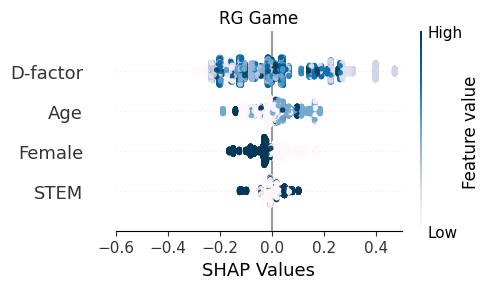

In [101]:
fig=plt.gcf()
shap.summary_plot(shap_values['s1']['Framing_1'], plot_type="dot",
                  plot_size=(5,3) ,show=False, alpha=0.9, cmap=cmap_c)
plt.title("RG Game")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim(bs_axes)

ax = plt.gca()
plt.tight_layout()

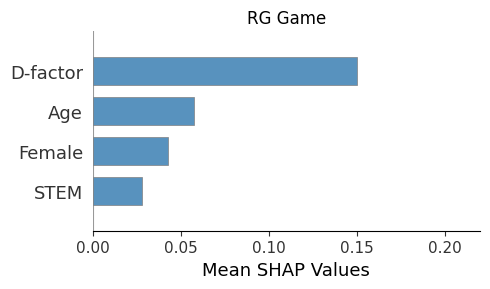

In [102]:
fig = plt.gcf()
shap.summary_plot(shap_values['s1']['Framing_1'], plot_type="bar", color='#5892BE',
                  plot_size=(5,3), show=False)
plt.title("RG Game")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim(bar_axes)
plt.tight_layout()

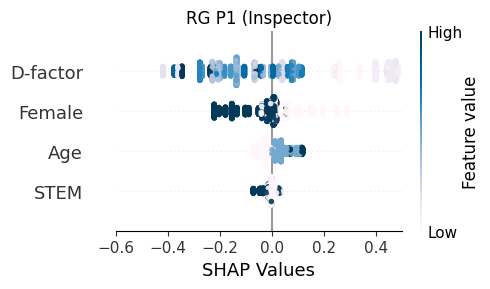

In [103]:
fig=plt.gcf()
shap.summary_plot(shap_values_p1['s1']['Framing_1'], plot_type="dot",
                  plot_size=(5,3) ,show=False, alpha=0.9, cmap=cmap_c)
plt.title("RG P1 (Inspector)")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim(bs_axes)

ax = plt.gca()
plt.tight_layout()

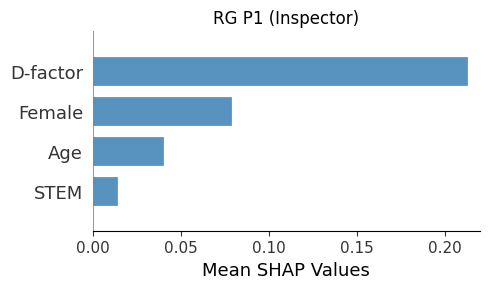

In [104]:
fig = plt.gcf()
shap.summary_plot(shap_values_p1['s1']['Framing_1'], plot_type="bar", color='#5892BE',
                  plot_size=(5,3), show=False)
plt.title("RG P1 (Inspector)")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim(bar_axes)
plt.tight_layout()

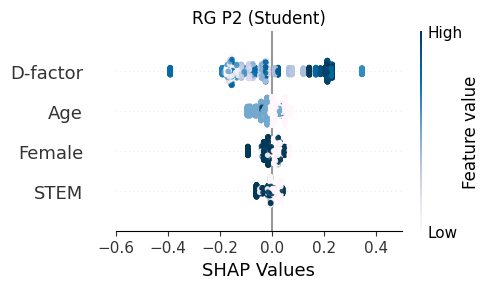

In [105]:
fig=plt.gcf()
shap.summary_plot(shap_values_p2['s1']['Framing_1'], plot_type="dot",
                  plot_size=(5,3) ,show=False, alpha=0.9, cmap=cmap_c)
plt.title("RG P2 (Student)")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim(bs_axes)

ax = plt.gca()
plt.tight_layout()

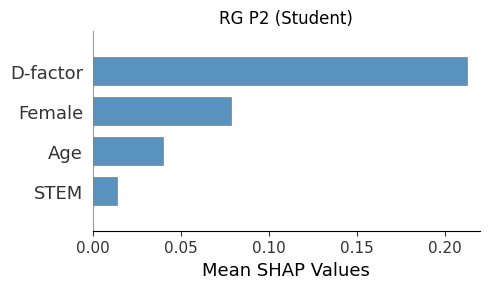

In [107]:
fig = plt.gcf()
shap.summary_plot(shap_values_p1['s1']['Framing_1'], plot_type="bar", color='#5892BE',
                  plot_size=(5,3), show=False)
plt.title("RG P2 (Student)")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim(bar_axes)
plt.tight_layout()

#### CATE on the Observation Level

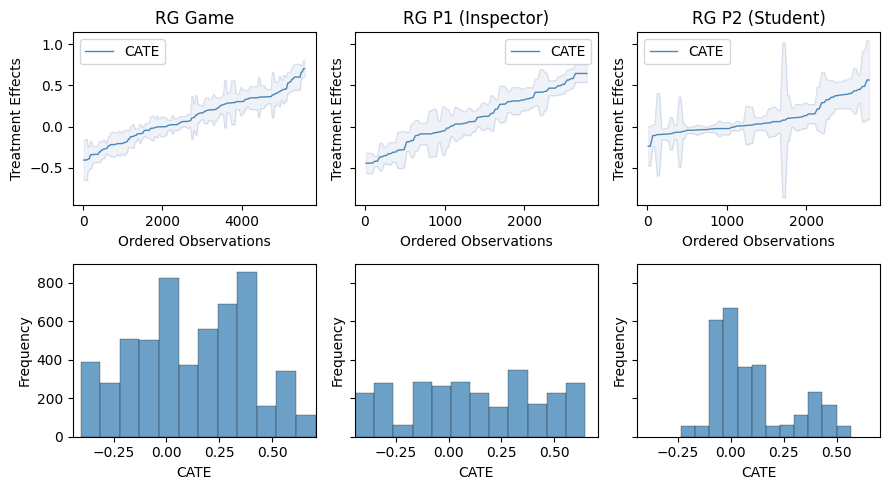

In [93]:
models_dict = {
    'RG Game': (model_g, X),
    'RG P1 (Inspector)': (model_p1, X_1),
    'RG P2 (Student)': (model_p2, X_2),
}
plot_treatment_effects(models_dict)

## One-Shot Game

### Evaluating, Selecting and Assembling Models T and Y

In [48]:
%%time
model_t_os = model_selection(X_os, T_os, model_type='classifier', groups=None, use_groups=False, 
                               cv_folds=5 ,dataset = 'os')
model_y_os = model_selection(X_os, y_os, model_type='classifier', groups=None, use_groups=False, 
                               cv_folds=5 ,dataset = 'os')
save_model(model_t_os, 'ml_models/model_t_os.joblib')
save_model(model_y_os, 'ml_models/model_y_os.joblib')

Models Evaluation Started...

MLPClassifier started
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
MLPClassifier finished

RandomForestClassifier started
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
RandomForestClassifier finished

GradientBoostingClassifier started
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
GradientBoostingClassifier finished

GaussianNB started
Fitting 5 folds for each of 1 candidates, totalling 5 fits
GaussianNB finished

Scores of all models:  {'MLPClassifier': 0.5643332362082363, 'RandomForestClassifier': 0.5235390766640766, 'GradientBoostingClassifier': 0.5318008611758611, 'GaussianNB': 0.4629663623413623}
Best score: 0.5643332362082363
Selected Model: MLPClassifier
Model Architecture: {'model__activation': 'relu', 'model__alpha': 0.25, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate': 'constant', 'model__learning_rate_init': 0.2, 'model__solver': 'adam', 'model__warm_start': False}

Models Eva

In [49]:
%%time
model_t_1_os = model_selection(X_1_os, T_1_os, model_type='classifier', groups=None, use_groups=False, 
                               cv_folds=5 ,dataset = 'os')
model_y_1_os = model_selection(X_1_os, y_1_os, model_type='classifier', groups=None, use_groups=False, 
                               cv_folds=5 ,dataset = 'os')
save_model(model_t_1_os, 'ml_models/model_t_1_os.joblib')
save_model(model_y_1_os, 'ml_models/model_y_1_os.joblib')

Models Evaluation Started...

MLPClassifier started
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
MLPClassifier finished

RandomForestClassifier started
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
RandomForestClassifier finished

GradientBoostingClassifier started
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
GradientBoostingClassifier finished

GaussianNB started
Fitting 5 folds for each of 1 candidates, totalling 5 fits
GaussianNB finished

Scores of all models:  {'MLPClassifier': 0.5842094413522985, 'RandomForestClassifier': 0.5363017934446506, 'GradientBoostingClassifier': 0.5580189651618224, 'GaussianNB': 0.50849309420738}
Best score: 0.5842094413522985
Selected Model: MLPClassifier
Model Architecture: {'model__activation': 'tanh', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (100,), 'model__learning_rate': 'invscaling', 'model__learning_rate_init': 0.2, 'model__solver': 'sgd', 'model__warm_start': False}

Models Evalua

In [50]:
%%time
model_t_2_os = model_selection(X_2_os, T_2_os, model_type='classifier', groups=None, use_groups=False, 
                               cv_folds=5 ,dataset = 'os')
model_y_2_os = model_selection(X_2_os, y_2_os, model_type='classifier', groups=None, use_groups=False, 
                               cv_folds=5, dataset = 'os')
save_model(model_t_2_os, 'ml_models/model_t_2_os.joblib')
save_model(model_y_2_os, 'ml_models/model_y_2_os.joblib')

Models Evaluation Started...

MLPClassifier started
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
MLPClassifier finished

RandomForestClassifier started
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
RandomForestClassifier finished

GradientBoostingClassifier started
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
GradientBoostingClassifier finished

GaussianNB started
Fitting 5 folds for each of 1 candidates, totalling 5 fits
GaussianNB finished

Scores of all models:  {'MLPClassifier': 0.5970002080299563, 'RandomForestClassifier': 0.5396567505720824, 'GradientBoostingClassifier': 0.5501294986478052, 'GaussianNB': 0.5172134387351779}
Best score: 0.5970002080299563
Selected Model: MLPClassifier
Model Architecture: {'model__activation': 'tanh', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (50,), 'model__learning_rate': 'constant', 'model__learning_rate_init': 0.1, 'model__solver': 'adam', 'model__warm_start': False}

Models Evalua

### Tuning DML Models

In [51]:
tune_CausalForestDML( 'ml_models/model_y_os.joblib', 'ml_models/model_t_os.joblib', 
                     y_os, T_os, X_os, None, 'dml_models/dml_game_os.joblib')

dml_models/dml_game_os.joblib model saved


In [52]:
tune_CausalForestDML( 'ml_models/model_y_1_os.joblib', 'ml_models/model_t_1_os.joblib', 
                     y_1_os, T_1_os, X_1_os, None, 'dml_models/dml_p1_os.joblib')

dml_models/dml_p1_os.joblib model saved


In [53]:
tune_CausalForestDML( 'ml_models/model_y_2_os.joblib', 'ml_models/model_t_2_os.joblib',
                     y_2_os, T_2_os, X_2_os, None, 'dml_models/dml_p2_os.joblib')

dml_models/dml_p2_os.joblib model saved


### Fitting DML Models

In [16]:
model_g_os, te_X_g_os, rmse_g_os, mae_g_os = fit_tuned_CausalForestDML(y_os, T_os, X_os, None, 
                                                                       'dml_models/dml_game_os.joblib')

Finished


In [17]:
model_p1_os, te_X_p1_os, rmse_p1_os, mae_p1_os = fit_tuned_CausalForestDML(y_1_os, T_1_os, X_1_os, None,  
                                                                     'dml_models/dml_p1_os.joblib')

Finished


In [18]:
model_p2_os, te_X_p2_os, rmse_p2_os, mae_p2_os = fit_tuned_CausalForestDML(y_2_os, T_2_os, X_2_os, None, 
                                                                     'dml_models/dml_p2_os.joblib')

Finished


### Evaluation and Analysis

#### General Models Summary

In [19]:
print("Models Performance Metrics:\n")
print(f"Game Model: RMSE={rmse_g_os:.3f}, MAE={mae_g_os:.3f}")
print(f"P1 Model: RMSE={rmse_p1_os:.3f}, MAE={mae_p1_os:.3f}")
print(f"P2 Model: RMSE={rmse_p2_os:.3f}, MAE={mae_p2_os:.3f}")

Models Performance Metrics:

Game Model: RMSE=0.600, MAE=0.411
P1 Model: RMSE=0.602, MAE=0.552
P2 Model: RMSE=0.466, MAE=0.240


In [20]:
model_g_os.summary() # model for the game

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.058,0.061,0.952,0.341,-0.061,0.177
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.766,0.073,-10.469,0.0,-0.909,-0.623
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.779,0.063,12.444,0.0,0.656,0.901


In [21]:
model_p1_os.summary() # model for player 1

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.131,0.11,1.193,0.233,-0.084,0.347
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-1.101,0.113,-9.762,0.0,-1.323,-0.88
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,1.375,0.08,17.131,0.0,1.218,1.533


In [22]:
model_p2_os.summary() # model for player 2

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-7.713,2.015,-3.828,0.0,-11.663,-3.764
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-16.697,4.159,-4.015,0.0,-24.848,-8.545
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.067,0.024,2.782,0.005,0.02,0.114


#### Shapley Values (SHAP)

In [23]:
shap_values_os = model_g_os.shap_values(X_os)

In [24]:
shap_values_p1_os = model_p1_os.shap_values(X_1_os)

In [25]:
shap_values_p2_os = model_p2_os.shap_values(X_2_os)

In [64]:
cmap_c = 'PuBu'
bs_axes_os = [-0.2, 0.2]
bar_axes_os = [0, 0.07]

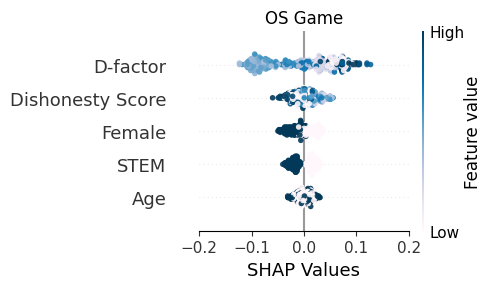

In [95]:
fig=plt.gcf()
shap.summary_plot(shap_values_os['s1']['Framing_1'], plot_type="dot",
                  plot_size=(5,3) ,show=False, alpha=0.9, cmap=cmap_c)
plt.title("OS Game")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim(bs_axes_os)

ax = plt.gca()
plt.tight_layout()
plt.show()

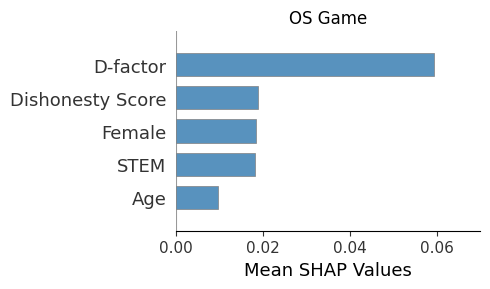

In [66]:
fig = plt.gcf()
shap.summary_plot(shap_values_os['s1']['Framing_1'], plot_type="bar", color='#5892BE',
                  plot_size=(5,3), show=False)
plt.title("OS Game")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim(bar_axes_os)
plt.tight_layout()

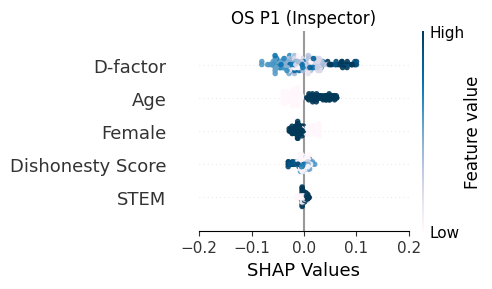

In [67]:
fig=plt.gcf()
shap.summary_plot(shap_values_p1_os['s1']['Framing_1'], plot_type="dot",
                  plot_size=(5,3) ,show=False, alpha=0.9, cmap=cmap_c)
plt.title("OS P1 (Inspector)")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim(bs_axes_os)

ax = plt.gca()
plt.tight_layout()

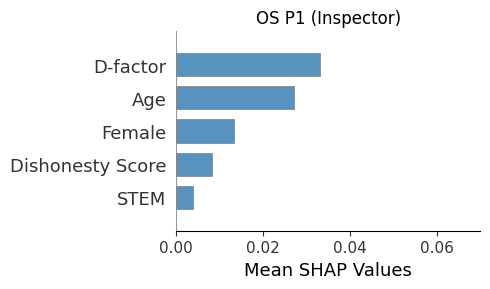

In [68]:
fig = plt.gcf()
shap.summary_plot(shap_values_p1_os['s1']['Framing_1'], plot_type="bar", color='#5892BE',
                  plot_size=(5,3), show=False)
plt.title("OS P1 (Inspector)")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim(bar_axes_os)
plt.tight_layout()

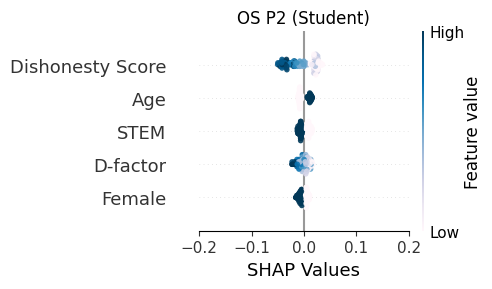

In [69]:
fig=plt.gcf()
shap.summary_plot(shap_values_p2_os['s1']['Framing_1'], plot_type="dot",
                  plot_size=(5,3) ,show=False, alpha=0.9, cmap=cmap_c)
plt.title("OS P2 (Student)")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim(bs_axes_os)

ax = plt.gca()
plt.tight_layout()

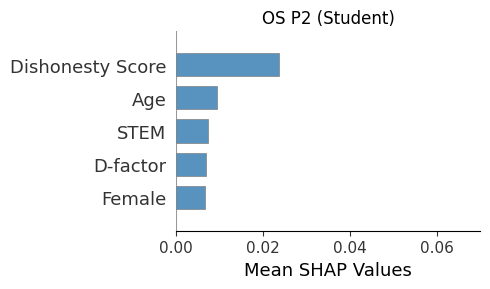

In [70]:
fig = plt.gcf()
shap.summary_plot(shap_values_p2_os['s1']['Framing_1'], plot_type="bar", color='#5892BE',
                  plot_size=(5,3), show=False)
plt.title("OS P2 (Student)")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim(bar_axes_os)
plt.tight_layout()

#### CATE on the Observation Level

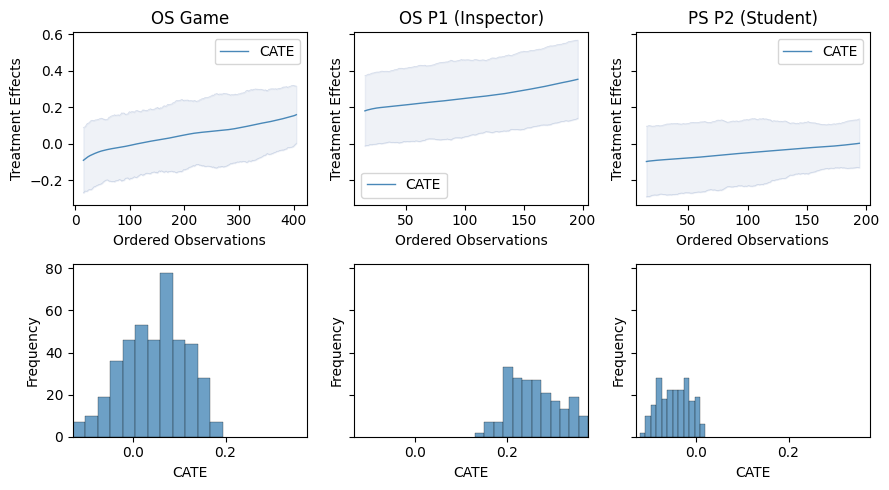

In [94]:
models_dict_os = {
    'OS Game': (model_g_os, X_os),
    'OS P1 (Inspector)': (model_p1_os, X_1_os),
    'PS P2 (Student)': (model_p2_os, X_2_os),
}

plot_treatment_effects(models_dict_os)

## CATE Predictions

In [26]:
model_data_dict = {
    'model_g': {'model': model_g, 'X_test': X_test, 'y_test': y_test},
    'model_p1': {'model': model_p1, 'X_test': X_test_1, 'y_test': y_test_1},
    'model_p2': {'model': model_p2, 'X_test': X_test_2, 'y_test': y_test_2},
    
    'model_g_os': {'model': model_g_os, 'X_test': X_test_os, 'y_test': y_test_os},
    'model_p1_os': {'model': model_p1_os, 'X_test': X_test_1_os, 'y_test': y_test_1_os},
    'model_p2_os': {'model': model_p2_os, 'X_test': X_test_2_os, 'y_test': y_test_2_os},
}

results_df = predict_CATE(model_data_dict)
results_df

,Model,ATE,RMSE,MAE
0,model_g,0.106555,0.531905,0.392987
1,model_p1,0.112199,0.634943,0.516075
2,model_p2,0.091354,0.357993,0.225905
3,model_g_os,0.038783,0.555893,0.364655
4,model_p1_os,0.237655,0.539493,0.469739
5,model_p2_os,-0.035512,0.410272,0.189435
